# USPS Handwritten Digit Classification

This notebook implements Decision Tree, K-Nearest Neighbors (from scratch), and Multiclass SVM models to classify USPS handwritten digits. It also provides automated insights into model performance.

In [22]:
import scipy.io
import numpy as np
import time
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter

## Data Loading

In [23]:
def load_data(path):
    mat = scipy.io.loadmat(path)
    X = mat['fea']
    y = mat['gnd'].flatten()
    
    # Split data
    X_train = X[:7291]
    y_train = y[:7291]
    X_test = X[7291:]
    y_test = y[7291:]
    
    # Normalize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test

## Decision Tree Model

In [24]:
def train_evaluate_dt(X_train, y_train, X_test, y_test):
    print("\n" + "="*50)
    print("DECISION TREE MODEL")
    print("="*50)
    results = []
    
    # 2.1.1 Print out the tree (using default params first or a small one)
    dt_default = DecisionTreeClassifier(random_state=42)
    dt_default.fit(X_train, y_train)
    print("Decision Tree Structure:")
    print(export_text(dt_default, feature_names=[f'pixel_{i}' for i in range(X_train.shape[1])]))
    
    # Plot the tree
    plt.figure(figsize=(20,10))
    plot_tree(dt_default, max_depth=2, feature_names=[f'pixel_{i}' for i in range(X_train.shape[1])], filled=True)
    plt.title("Decision Tree Visualization (Top Levels)")
    plt.show()
    
    # 2.1.2 Variations
    configs = [
        {},
        {'max_leaf_nodes': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'},
        {'max_leaf_nodes': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'gini'},
        {'max_leaf_nodes': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'gini'},
        {'max_leaf_nodes': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'},
    ]
    
    for config in configs:
        start_time = time.time()
        clf = DecisionTreeClassifier(random_state=42, **config)
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results.append({
            'model': 'Decision Tree',
            'config': config,
            'accuracy': acc,
            'confusion_matrix': cm,
            'time': train_time
        })
        print(f"Config: {config}, Accuracy Rate: {acc:.2%}, Training Time: {train_time:.4f}s")
        
        # Plot Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'DT Confusion Matrix\n{config}')
        plt.show()
        
    return results

## K-Nearest Neighbors

In [25]:
def train_evaluate_knn(X_train, y_train, X_test, y_test):
    print("\n" + "="*50)
    print("K-NEAREST NEIGHBORS MODEL")
    print("="*50)
    results = []
    
    # 2.2.1 Different values of k
    k_values = [1, 3, 5, 7]
    
    for k in k_values:
        start_time = time.time()
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(X_train, y_train)
        # Training time for KNN is 0 technically, but let's include fit time
        train_time = time.time() - start_time
        
        # Prediction time is the heavy part
        pred_start = time.time()
        y_pred = knn.predict(X_test)
        pred_time = time.time() - pred_start
        
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results.append({
            'model': 'KNN',
            'config': {'k': k, 'weights': 'distance'},
            'accuracy': acc,
            'confusion_matrix': cm,
            'time': train_time + pred_time # Total time
        })
        print(f"k={k}, weights='distance', Accuracy Rate: {acc:.2%}, Training Time: {train_time + pred_time:.4f}s")
        
        # Plot Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'KNN Confusion Matrix (k={k}, distance)')
        plt.show()

    # 2.2.2 Distance weighting
    start_time = time.time()
    knn_dist = KNeighborsClassifier(n_neighbors=3, weights='uniform')
    knn_dist.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    pred_start = time.time()
    y_pred = knn_dist.predict(X_test)
    pred_time = time.time() - pred_start
    
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        'model': 'KNN',
        'config': {'k': 3, 'weights': 'uniform'},
        'accuracy': acc,
        'confusion_matrix': cm,
        'time': train_time + pred_time
    })
    print(f"k=3, weights='uniform', Accuracy Rate: {acc:.2%}, Training Time: {train_time + pred_time:.4f}s")
    
    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'KNN Confusion Matrix (k=3, uniform)')
    plt.show()
    
    return results

## Support Vector Machine Model

In [26]:
def train_evaluate_svm(X_train, y_train, X_test, y_test):
    print("\n" + "="*50)
    print("SUPPORT VECTOR MACHINE MODEL")
    print("="*50)
    results = []
    
    configs = [
        {'kernel': 'linear', 'decision_function_shape': 'ovr'},
        {'kernel': 'poly', 'decision_function_shape': 'ovr', 'degree': 2}, # Polynomial degree 2
        {'kernel': 'poly', 'decision_function_shape': 'ovr', 'degree': 3}, # Polynomial degree 3
    ]
    
    for config in configs:
        start_time = time.time()
        clf = SVC(**config)
        clf.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results.append({
            'model': 'SVM',
            'config': config,
            'accuracy': acc,
            'confusion_matrix': cm,
            'time': train_time
        })
        print(f"Config: {config}, Accuracy Rate: {acc:.2%}, Training Time: {train_time:.4f}s")
        
        # Plot Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'SVM Confusion Matrix\n{config}')
        plt.show()
        
    return results

## Insights and Analysis Function

In [27]:
def analyze_results(results):
    print("\n" + "="*50)
    print("AUTOMATED INSIGHTS & ANALYSIS")
    print("="*50)
    
    # 1. Per-Model Instance Analysis
    print("\n--- 1. Worst Performing Class per Model Instance ---")
    
    overall_class_accuracies = {} # digit -> list of accuracies across all models
    
    for res in results:
        cm = res['confusion_matrix']
        # Calculate per-class accuracy
        # Avoid division by zero
        row_sums = cm.sum(axis=1)
        with np.errstate(divide='ignore', invalid='ignore'):
            class_acc = np.diag(cm) / row_sums
            class_acc = np.nan_to_num(class_acc) # Replace NaNs with 0 if any class has 0 samples
        
        # Track for overall analysis
        for digit, acc in enumerate(class_acc):
            if digit not in overall_class_accuracies:
                overall_class_accuracies[digit] = []
            overall_class_accuracies[digit].append(acc)
            
        worst_class = np.argmin(class_acc)
        worst_acc = class_acc[worst_class]
        
        # Find most frequent misclassification
        # Mask diagonal to ignore correct predictions
        np.fill_diagonal(cm, 0)
        # Find index of max value
        if cm.sum() > 0:
            mis_idx = np.unravel_index(np.argmax(cm, axis=None), cm.shape)
            true_label, pred_label = mis_idx
            mis_count = cm[true_label, pred_label]
            mis_desc = f"Digit {true_label} often confused as {pred_label} ({mis_count} times)"
        else:
            mis_desc = "None"
            
        print(f"\nModel: {res['model']}")
        print(f"Config: {res['config']}")
        print(f"  -> Worst Class: Digit {worst_class} (Accuracy Rate: {worst_acc:.2%})")
        print(f"  -> Most Frequent Misclassification: {mis_desc}")

    # 2. Overall Hardest Digit
    print("\n--- 2. Overall Hardest & Easiest Digits ---")
    avg_class_acc = {d: np.mean(accs) for d, accs in overall_class_accuracies.items()}
    hardest_digit = min(avg_class_acc, key=avg_class_acc.get)
    easiest_digit = max(avg_class_acc, key=avg_class_acc.get)
    
    print(f"Hardest Digit to Classify (Avg Accuracy Rate): {hardest_digit} ({avg_class_acc[hardest_digit]:.2%})")
    print(f"Easiest Digit to Classify (Avg Accuracy Rate): {easiest_digit} ({avg_class_acc[easiest_digit]:.2%})")

    # 3. Comparative Explanations
    print("\n--- 3. Comparative Explanations ---")
    
    # SVM Analysis
    svm_results = [r for r in results if r['model'] == 'SVM']
    if svm_results:
        linear_acc = next((r['accuracy'] for r in svm_results if r['config']['kernel'] == 'linear'), 0)
        poly_acc = max((r['accuracy'] for r in svm_results if r['config']['kernel'] == 'poly'), default=0)
        
        print("\n[SVM Analysis]")
        if poly_acc > linear_acc:
            print(f"  - Polynomial kernel ({poly_acc:.2%}) outperformed Linear kernel ({linear_acc:.2%}).")
            print("  - Insight: The data is likely not linearly separable. Mapping to a higher-dimensional space helped separate the classes.")
        else:
            print(f"  - Linear kernel performed similarly or better than Polynomial.")
            print("  - Insight: The classes are reasonably well-separated by hyperplanes in the original feature space.")

    # KNN Analysis
    knn_results = [r for r in results if r['model'] == 'KNN' and r['config']['weights'] == 'uniform']
    if knn_results:
        # Sort by k
        knn_results.sort(key=lambda x: x['config']['k'])
        best_k_res = max(knn_results, key=lambda x: x['accuracy'])
        best_k = best_k_res['config']['k']
        
        print("\n[KNN Analysis]")
        print(f"  - Best k value was {best_k} with accuracy {best_k_res['accuracy']:.2%}.")
        if best_k <= 3:
            print("  - Insight: Lower k values performed well, suggesting that the decision boundaries are complex and local neighborhood structure is very informative.")
        else:
            print("  - Insight: Higher k values performed better, suggesting that smoothing the decision boundary helped reduce noise.")

    # Decision Tree Analysis
    dt_results = [r for r in results if r['model'] == 'Decision Tree']
    if dt_results:
        best_dt = max(dt_results, key=lambda x: x['accuracy'])
        worst_dt = min(dt_results, key=lambda x: x['accuracy'])
        
        print("\n[Decision Tree Analysis]")
        print(f"  - Best Config: {best_dt['config']} ({best_dt['accuracy']:.2%})")
        print(f"  - Worst Config: {worst_dt['config']} ({worst_dt['accuracy']:.2%})")
        
        if best_dt['config'].get('max_leaf_nodes') is None and worst_dt['config'].get('max_leaf_nodes') is not None:
             print("  - Insight: Restricting the tree size (max_leaf_nodes) significantly hurt performance, indicating that a complex tree is needed to capture the nuances of handwritten digits.")

## Main Execution

Train shape: (7291, 256), Test shape: (2007, 256)

DECISION TREE MODEL
Decision Tree Structure:
|--- pixel_66 <= -0.66
|   |--- pixel_189 <= -0.75
|   |   |--- pixel_55 <= -0.81
|   |   |   |--- pixel_107 <= -1.07
|   |   |   |   |--- pixel_72 <= 0.52
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- pixel_72 >  0.52
|   |   |   |   |   |--- class: 3
|   |   |   |--- pixel_107 >  -1.07
|   |   |   |   |--- class: 5
|   |   |--- pixel_55 >  -0.81
|   |   |   |--- pixel_199 <= -0.81
|   |   |   |   |--- class: 7
|   |   |   |--- pixel_199 >  -0.81
|   |   |   |   |--- pixel_36 <= -1.14
|   |   |   |   |   |--- class: 7
|   |   |   |   |--- pixel_36 >  -1.14
|   |   |   |   |   |--- pixel_231 <= -1.28
|   |   |   |   |   |   |--- pixel_59 <= -1.18
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- pixel_59 >  -1.18
|   |   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |--- pixel_231 >  -1.28
|   |   |   |   |   |   |--- pixel_4 <= -0.67
|   |   |   |   |  

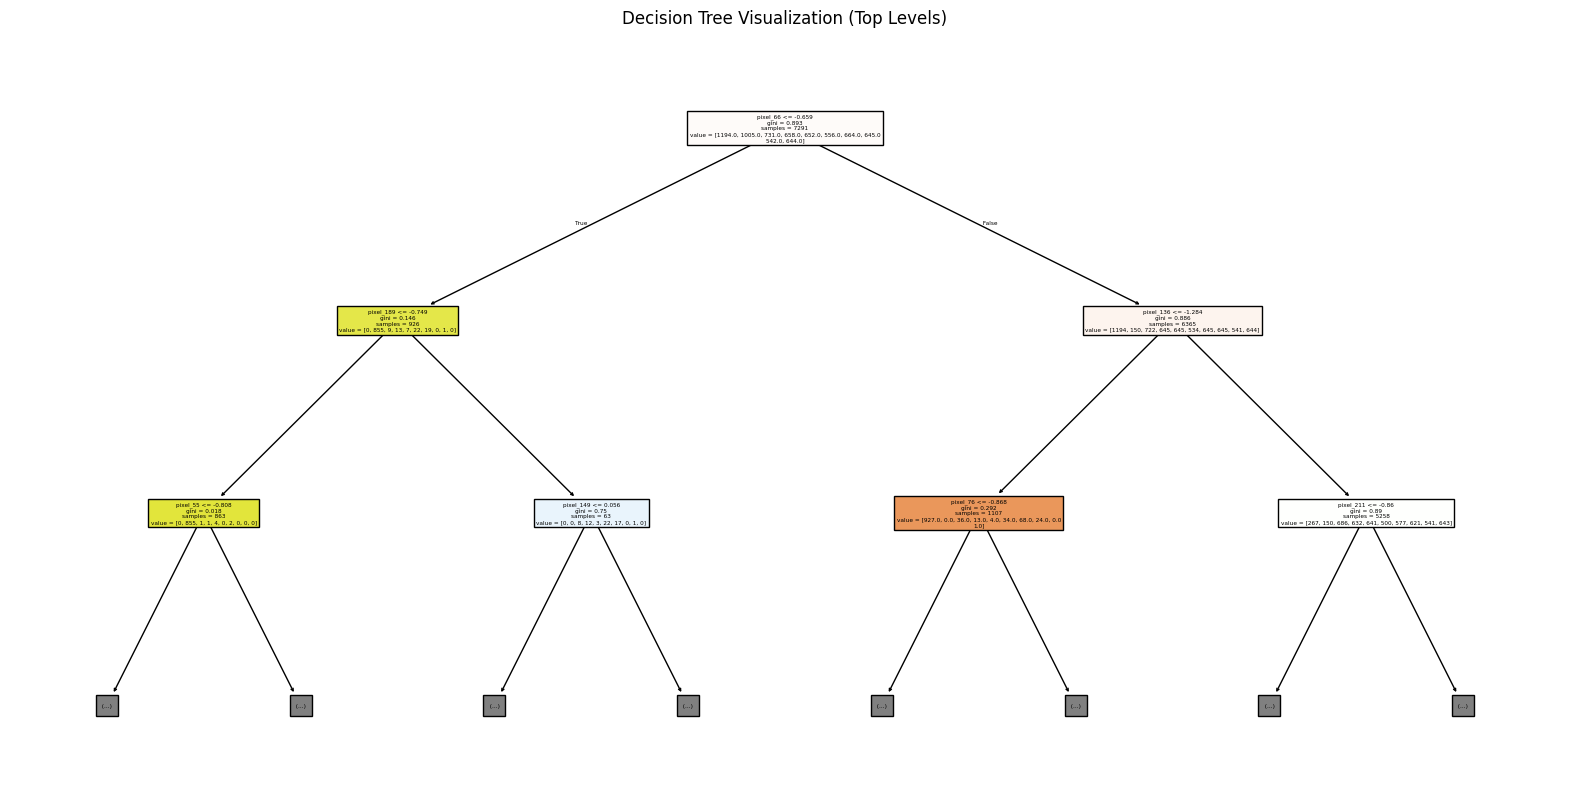

Config: {}, Accuracy Rate: 84.70%, Training Time: 7.9835s


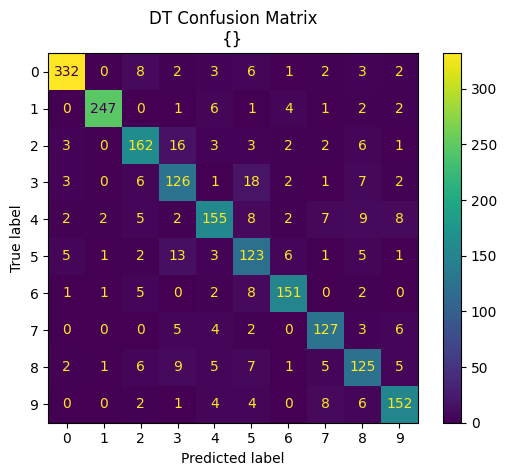

Config: {'max_leaf_nodes': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}, Accuracy Rate: 70.65%, Training Time: 2.5888s


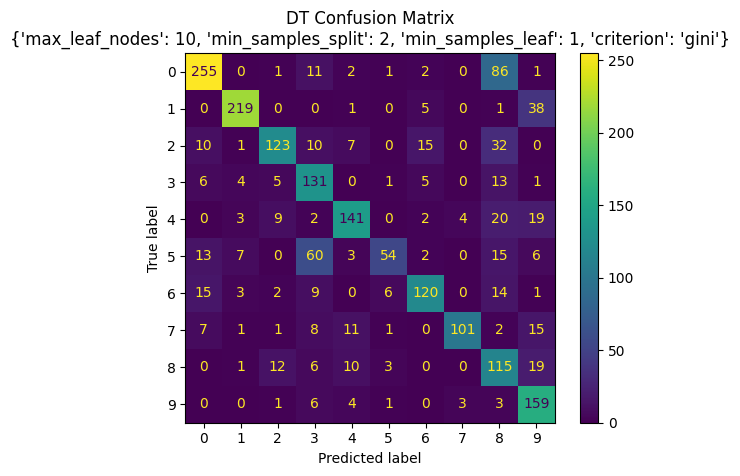

Config: {'max_leaf_nodes': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'gini'}, Accuracy Rate: 85.30%, Training Time: 5.3538s


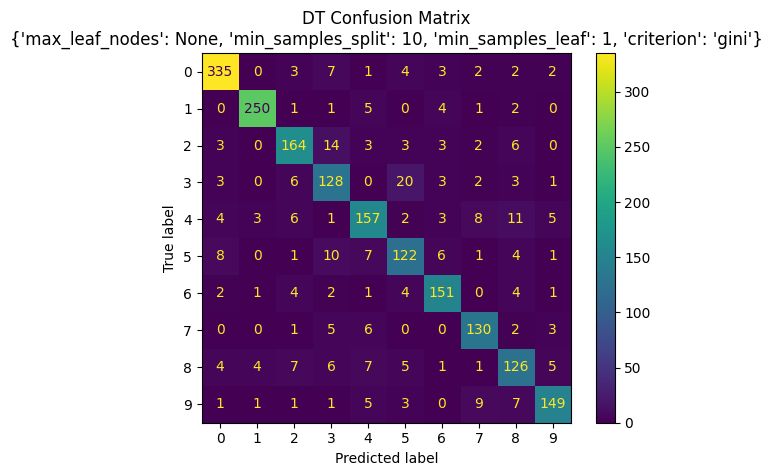

Config: {'max_leaf_nodes': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'gini'}, Accuracy Rate: 85.15%, Training Time: 5.5143s


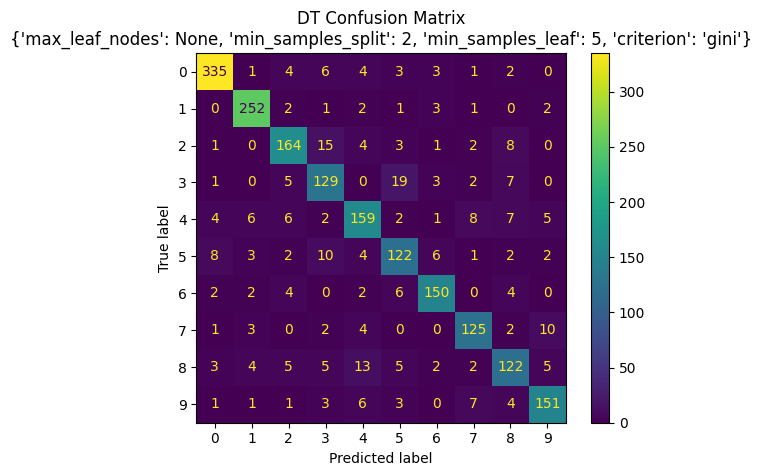

Config: {'max_leaf_nodes': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}, Accuracy Rate: 86.60%, Training Time: 7.6840s


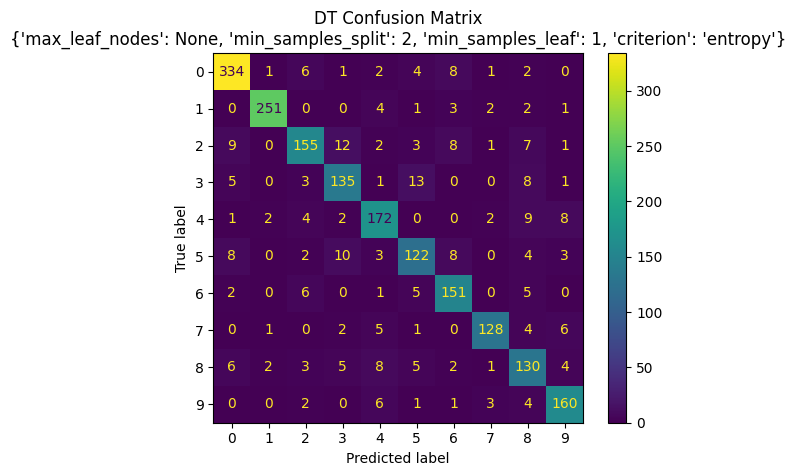


K-NEAREST NEIGHBORS MODEL
k=1, weights='distance', Accuracy Rate: 94.07%, Training Time: 0.4642s


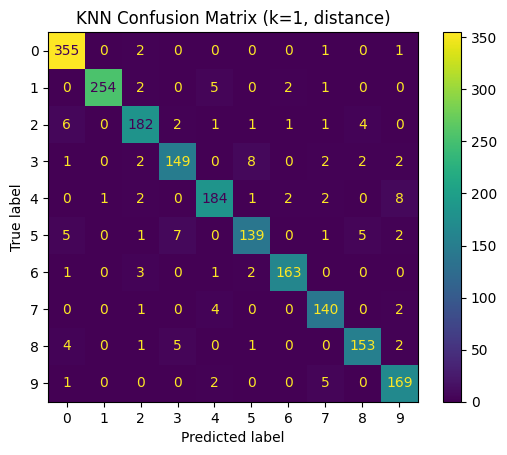

k=3, weights='distance', Accuracy Rate: 93.82%, Training Time: 0.8060s


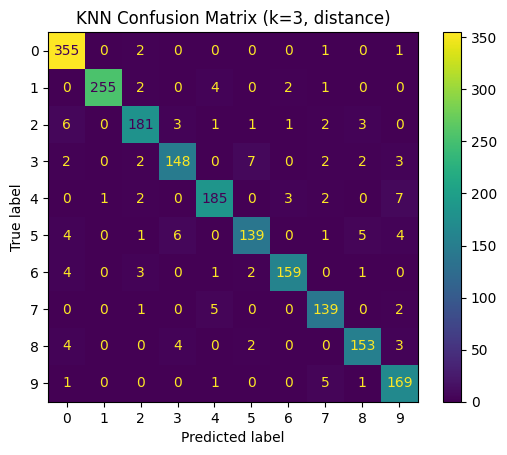

k=5, weights='distance', Accuracy Rate: 94.17%, Training Time: 0.7015s


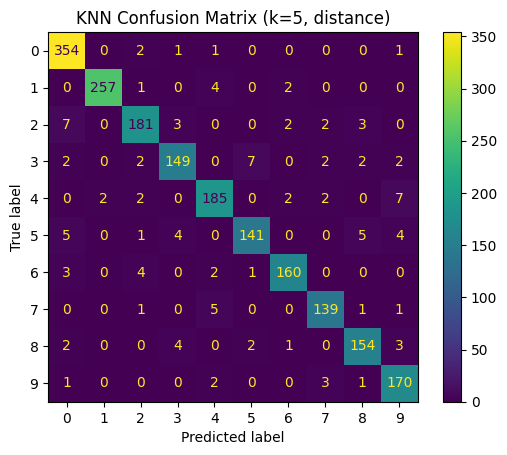

k=7, weights='distance', Accuracy Rate: 93.92%, Training Time: 0.5062s


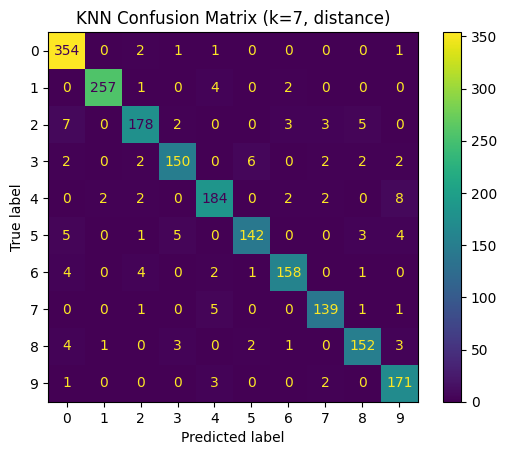

k=3, weights='uniform', Accuracy Rate: 93.67%, Training Time: 0.6955s


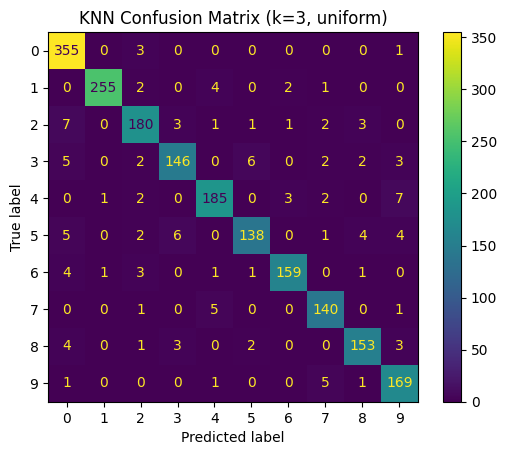


SUPPORT VECTOR MACHINE MODEL
Config: {'kernel': 'linear', 'decision_function_shape': 'ovr'}, Accuracy Rate: 92.73%, Training Time: 1.8850s


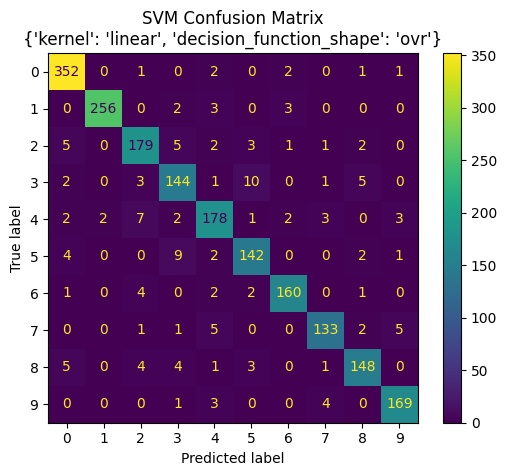

Config: {'kernel': 'poly', 'decision_function_shape': 'ovr', 'degree': 2}, Accuracy Rate: 93.77%, Training Time: 4.5420s


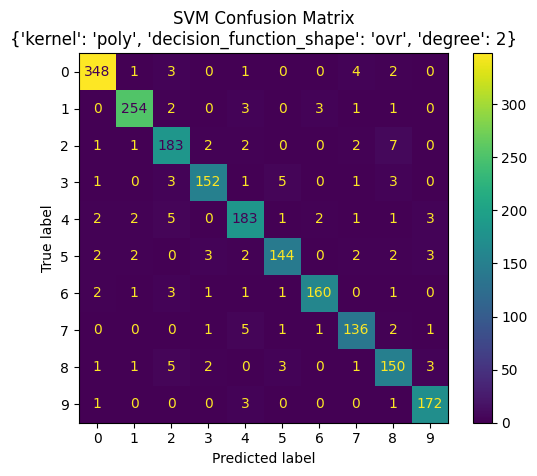

Config: {'kernel': 'poly', 'decision_function_shape': 'ovr', 'degree': 3}, Accuracy Rate: 94.37%, Training Time: 8.3470s


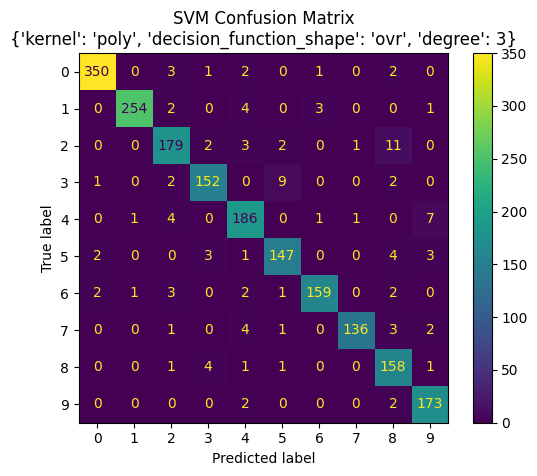


--- Final Comparison ---

Model: Decision Tree
  Config: {}
  Accuracy Rate: 84.70%
  Training Time: 7.9835s
  Config: {'max_leaf_nodes': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}
  Accuracy Rate: 70.65%
  Training Time: 2.5888s
  Config: {'max_leaf_nodes': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'gini'}
  Accuracy Rate: 85.30%
  Training Time: 5.3538s
  Config: {'max_leaf_nodes': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'gini'}
  Accuracy Rate: 85.15%
  Training Time: 5.5143s
  Config: {'max_leaf_nodes': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}
  Accuracy Rate: 86.60%
  Training Time: 7.6840s

Model: KNN
  Config: {'k': 1, 'weights': 'distance'}
  Accuracy Rate: 94.07%
  Training Time: 0.4642s
  Config: {'k': 3, 'weights': 'distance'}
  Accuracy Rate: 93.82%
  Training Time: 0.8060s
  Config: {'k': 5, 'weights': 'distance'}
  Accuracy Rate: 94.17%
  Training Time: 0.7

In [28]:
X_train, y_train, X_test, y_test = load_data('USPS_all.mat')
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

all_results = []

all_results.extend(train_evaluate_dt(X_train, y_train, X_test, y_test))
all_results.extend(train_evaluate_knn(X_train, y_train, X_test, y_test))
all_results.extend(train_evaluate_svm(X_train, y_train, X_test, y_test))

print("\n--- Final Comparison ---")
# Group by model
model_groups = {}
for res in all_results:
    model = res['model']
    if model not in model_groups:
        model_groups[model] = []
    model_groups[model].append(res)
    
for model, res_list in model_groups.items():
    print(f"\nModel: {model}")
    for res in res_list:
        print(f"  Config: {res['config']}")
        print(f"  Accuracy Rate: {res['accuracy']:.2%}")
        print(f"  Training Time: {res['time']:.4f}s")

analyze_results(all_results)